In [45]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader,Dataset
import torch.nn as nn
from torchvision import transforms,datasets
from PIL import ImageTk, Image
from torchvision import models
import os
import torch.optim as optim
import random

In [52]:
train_data_path = '/kaggle/input/dataset/Dataset/asl_alphabet_train'
test_data_path = '/kaggle/input/dataset/Dataset/asl_alphabet_test'

### Visualizing one image per class

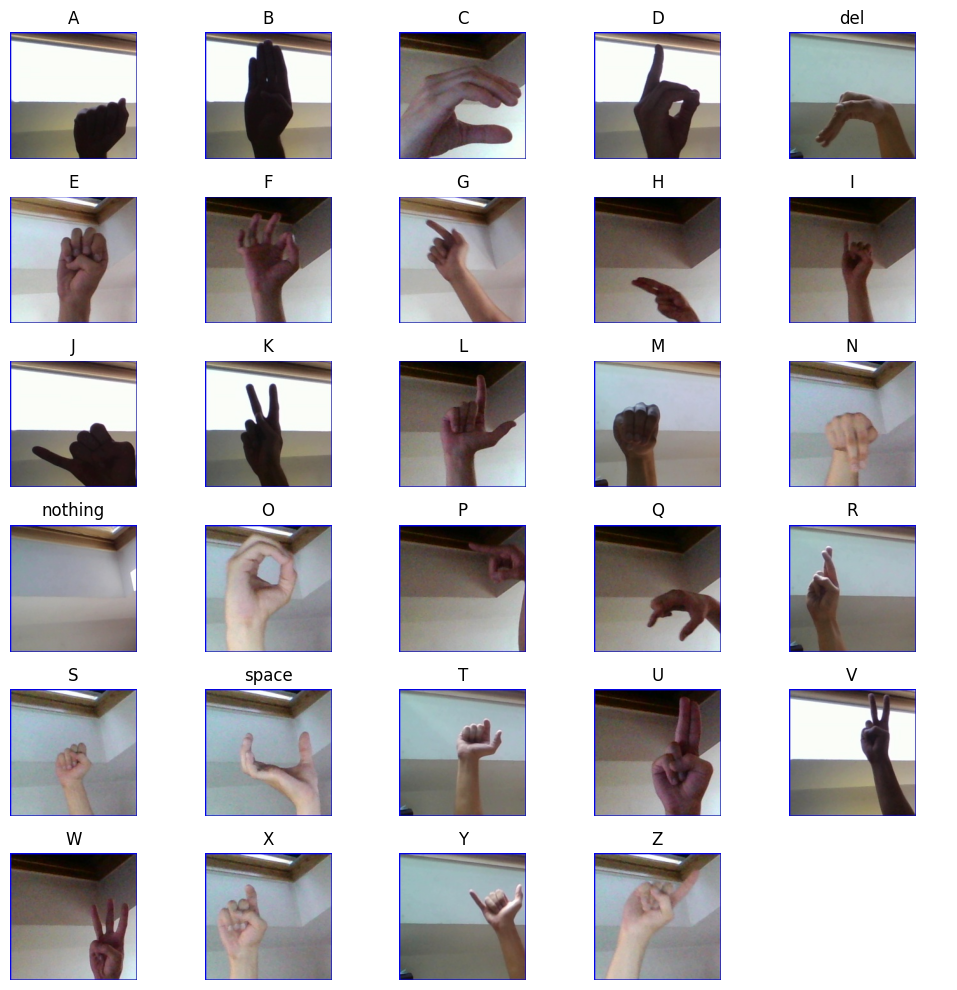

In [48]:
classes = os.listdir(train_data_path)
n_rows = 6
n_cols = 5

fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 10))
axs = axs.ravel()

for i, cls in enumerate(classes):
    if i >= n_rows * n_cols:
        break  # If there are more classes than grid spaces, stop adding images
    class_path = os.path.join(train_data_path, cls)
    image_files = os.listdir(class_path)
    random_image_file = random.choice(image_files)
    image_path = os.path.join(class_path, random_image_file)
    image = Image.open(image_path)
    axs[i].imshow(image)
    axs[i].set_title(cls)
    axs[i].axis('off')  # Turn off axis

# If there are less than 30 classes, turn off the empty subplots
for j in range(i + 1, n_rows * n_cols):
    axs[j].axis('off')

plt.tight_layout()
plt.show()

### Plot number of samples per class

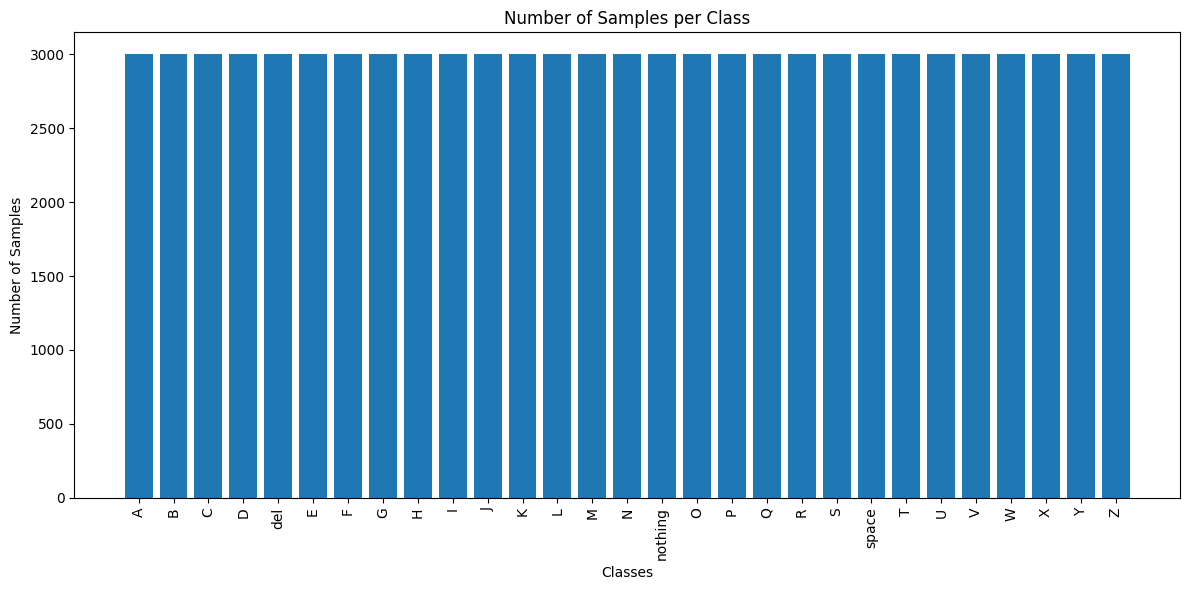

In [51]:

class_counts = {}

for class_folder in os.listdir(train_data_path):
    class_path = os.path.join(train_data_path, class_folder)
    
    if os.path.isdir(class_path):
        num_samples = len(os.listdir(class_path))
        class_counts[class_folder] = num_samples

class_names = list(class_counts.keys())
sample_counts = list(class_counts.values())

# Plot the histogram
plt.figure(figsize=(12, 6))
plt.bar(class_names, sample_counts)
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.title('Number of Samples per Class')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()

# Show the plot
plt.show()

### Define hyperparameters

In [37]:
test_size = 0.2
batch_size = 32
num_epoch = 10
learning_rate = 0.001
num_classes = 29

### Transforms to be applied on train and test set

In [38]:
train_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=(-15, 15)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize(224), 
    transforms.ToTensor()
])

### Class to load in the ASL dataset

In [39]:
class ASLDataset(Dataset):
    def __init__(self, root_dir, num_classes = 29, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []
        self.labels = []
        self.label_to_index = {}

        for i,label in enumerate(sorted(os.listdir(root_dir))):
            class_path = os.path.join(root_dir, label)
            self.label_to_index[label] = i
            if os.path.isdir(class_path):
                for img_file in os.listdir(class_path):
                    self.data.append(os.path.join(class_path, img_file))
                    self.labels.append(label)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        image = Image.open(img_path)
        label = self.labels[idx]
        image_untransformed = image.copy()

        label_index = self.label_to_index[label]


        if self.transform:
            image = self.transform(image)

        return image, label_index

### Load in the data

In [40]:
train_dataset = ASLDataset(train_data_path,transform=train_transforms)
train_dataset_untransformed = ASLDataset(train_data_path)
test_dataset = ASLDataset(test_data_path,transform = test_transforms)

In [41]:
validation_ratio = 0.2

### Split training data into training and validation

In [42]:
from torch.utils.data import random_split

total_size = len(train_dataset)
validation_size = int(validation_ratio*total_size)
train_size = total_size - validation_size
train_size, validation_size

train_dataset, validation_dataset = random_split(train_dataset, [train_size, validation_size])

In [43]:
train_size,validation_size

(69600, 17400)

### Load the data into dataloader 

In [29]:
train_loader = DataLoader(train_dataset, batch_size = 64, shuffle=True)
validation_loader = DataLoader(validation_dataset,batch_size=64)
test_loader = DataLoader(test_dataset)

### Custom CNN model class

In [10]:
class CNN(nn.Module):
    def __init__(self,num_classes):
        super(CNN,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32,kernel_size=3,padding=1)
        self.conv2 = nn.Conv2d(32,32,kernel_size=3,stride=1)
        self.conv3 = nn.Conv2d(32,64,kernel_size=3,padding=1)
        self.conv4 = nn.Conv2d(64,64,kernel_size=3,padding=1)

        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(64*27*27,1024)
        self.fc2 = nn.Linear(1024,256)
        self.fc3 = nn.Linear(256,num_classes)

        self.dropout = nn.Dropout(0.5)

        self.batch_normalization_1 = nn.BatchNorm2d(32)
        self.batch_normalization_2 = nn.BatchNorm2d(32)
        self.batch_normalization_3 = nn.BatchNorm2d(64)
        self.batch_normalization_4 = nn.BatchNorm2d(64)

    def forward(self,x):
        x = self.pool(torch.relu(self.batch_normalization_1(self.conv1(x))))
        x = self.pool(torch.relu(self.batch_normalization_2(self.conv2(x))))
        x = self.pool(torch.relu(self.batch_normalization_3(self.conv3(x))))
        x = torch.relu(self.batch_normalization_4(self.conv4(x)))
        x = torch.flatten(x,1)
        x = self.dropout(x)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
device = torch.device("mps" if torch.backends.mps.is_available() else device)

print(device)

cuda:0


### Instantiate the model

In [33]:
model = CNN(29).to(device)

### Define learning rate and number of epochs

In [35]:
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [36]:
from torch.optim.lr_scheduler import StepLR

### Function to train model

Deliverables - train-validation accuracy and losses

In [37]:
def train_model(model, train_loader, validation_loader,optimizer,num_epochs,device):
    criterion = nn.CrossEntropyLoss()

    scheduler = StepLR(optimizer,step_size=5,gamma=0.5)

    train_losses, train_accuracies = [], []
    val_losses , val_accuracies = [] , []

    for epoch in range(num_epochs):
        model.train()
        train_correct = 0
        train_loss = 0
        train_total = 0

        for b,(inputs,labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            train_outputs = model(inputs)
            loss = criterion(train_outputs,labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_total += labels.size(0)
            _, train_preds = torch.max(train_outputs.data,1)
            train_correct += (train_preds == labels).sum().item()
            print(f'epoch {epoch+1}/{num_epochs} batch: {b}/{len(train_loader)} loss:{loss.item():.3f}')
        
        train_accuracies.append((train_correct/train_total) * 100)
        train_losses.append(train_loss/len(train_loader))

        model.eval()

        val_correct = 0
        val_loss = 0
        val_total = 0
        with torch.no_grad():
            for inputs,labels in validation_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                val_outputs = model(inputs)
                loss = criterion(val_outputs,labels)

                val_total += labels.size(0)
                _,val_preds = torch.max(val_outputs,1)
                val_loss += loss.item()
                val_correct += (val_preds == labels).sum().item()
            
            val_losses.append(val_loss/len(validation_loader))
            val_accuracies.append(100 * val_correct/val_total)
        
        scheduler.step()

        file_path = 'sign_language_detection.pth'
        torch.save(model.state_dict(), file_path)
        
        print(f"Epoch {epoch+1}/{num_epochs} Training Loss: {train_loss/len(train_loader):.4f}, Training Accuracy: {(train_correct/train_total) * 100:.2f}% Validation Loss: {val_loss/len(validation_loader):.4f}, Validation Accuracy: {100 * val_correct/val_total:.2f}%")
        
    return train_losses,train_accuracies,val_losses,val_accuracies

In [38]:
train_loss , train_accuracy, val_loss, val_accuracy = train_model(model,train_loader,validation_loader, optimizer,10,device)

epoch 1/10 batch: 0/1088 loss:3.373
epoch 1/10 batch: 1/1088 loss:6.639
epoch 1/10 batch: 2/1088 loss:5.211
epoch 1/10 batch: 3/1088 loss:4.774
epoch 1/10 batch: 4/1088 loss:4.628
epoch 1/10 batch: 5/1088 loss:3.911
epoch 1/10 batch: 6/1088 loss:3.741
epoch 1/10 batch: 7/1088 loss:3.723
epoch 1/10 batch: 8/1088 loss:3.800
epoch 1/10 batch: 9/1088 loss:3.637
epoch 1/10 batch: 10/1088 loss:3.497
epoch 1/10 batch: 11/1088 loss:3.433
epoch 1/10 batch: 12/1088 loss:3.553
epoch 1/10 batch: 13/1088 loss:3.508
epoch 1/10 batch: 14/1088 loss:3.422
epoch 1/10 batch: 15/1088 loss:3.433
epoch 1/10 batch: 16/1088 loss:3.471
epoch 1/10 batch: 17/1088 loss:3.425
epoch 1/10 batch: 18/1088 loss:3.364
epoch 1/10 batch: 19/1088 loss:3.397
epoch 1/10 batch: 20/1088 loss:3.517
epoch 1/10 batch: 21/1088 loss:3.434
epoch 1/10 batch: 22/1088 loss:3.440
epoch 1/10 batch: 23/1088 loss:3.388
epoch 1/10 batch: 24/1088 loss:3.387
epoch 1/10 batch: 25/1088 loss:3.430
epoch 1/10 batch: 26/1088 loss:3.393
epoch 1/10 

### Plot of Train and validation loss

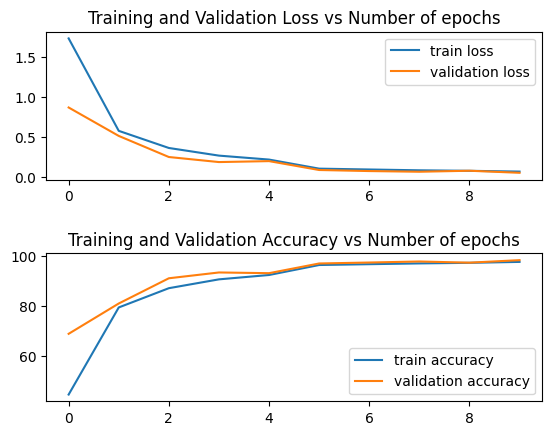

In [65]:
plt.figure()
plt.subplot(2,1,1)
plt.plot(range(num_epoch),train_loss,label='train loss')
plt.plot(range(num_epoch),val_loss,label='validation loss')
plt.legend()
plt.title('Training and Validation Loss vs Number of epochs')
plt.subplot(2,1,2)
plt.plot(range(num_epoch),train_accuracy,label ='train accuracy')
plt.plot(range(num_epoch),val_accuracy,label  = 'validation accuracy')
plt.legend()
plt.title('Training and Validation Accuracy vs Number of epochs')
plt.subplots_adjust(hspace=0.5)

### Function to obtain predictions on the test set

In [56]:
def inference(model,test_loader,device):
    test_correct = 0
    test_loss = 0
    test_total = 0
    test_losses, test_accuracies = [],[]
    with torch.no_grad():
        for inputs,labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            test_outputs = model(inputs)
            loss = criterion(test_outputs,labels)

            test_total += labels.size(0)
            _,test_preds = torch.max(test_outputs,1)
            test_loss += loss.item()
            test_correct += (test_preds == labels).sum().item()

        test_losses.append(test_loss/len(test_loader))
        test_accuracies.append(100 * test_correct/test_total)
    
    return test_losses, test_accuracies

### Testing the model on the given test set

In [64]:
test_loss , test_accuracy = inference(model,test_loader,device)

In [69]:
print(f'The accuracy on the test set is {test_accuracy[0]}')

The accuracy on the test set is 98.24712643678161
